
✓ Stage 17 complete — artefacts saved to C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250609\stage17



<Figure size 660x550 with 0 Axes>

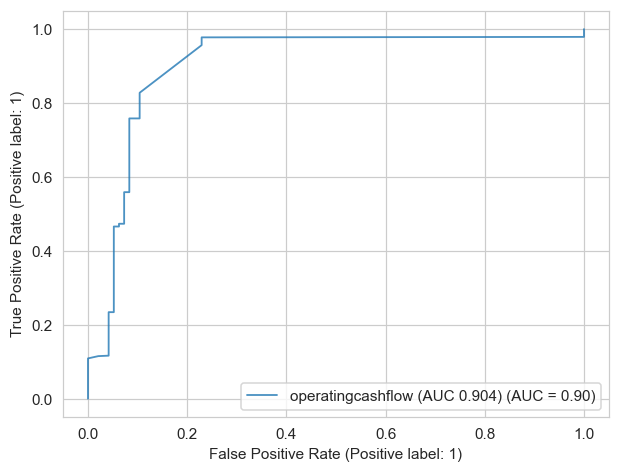

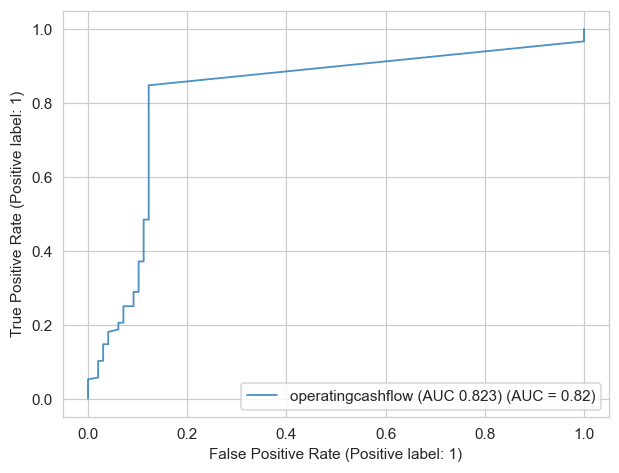

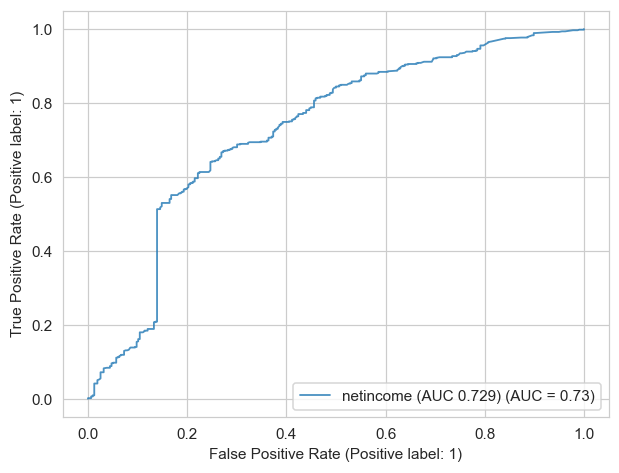

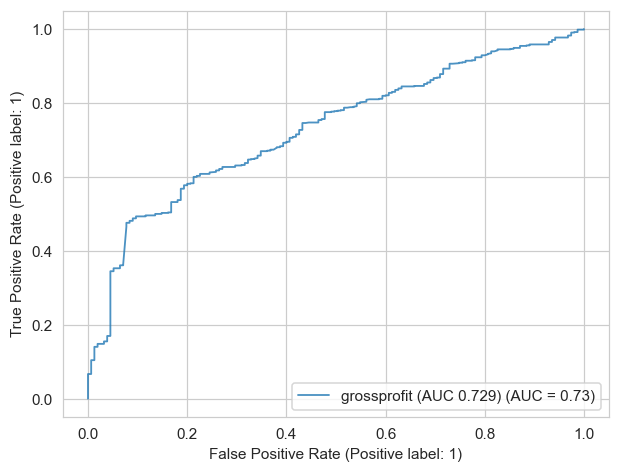

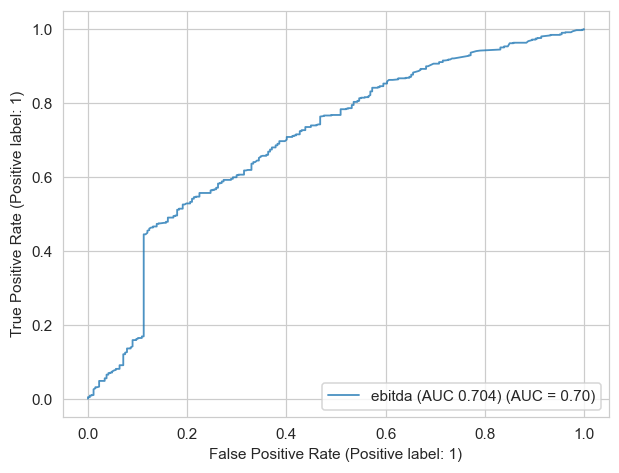

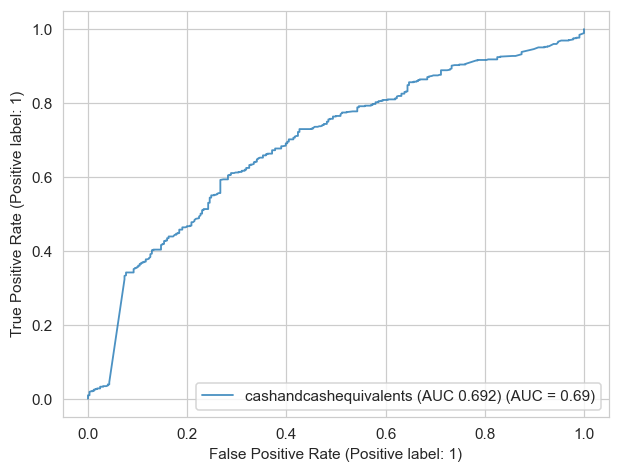

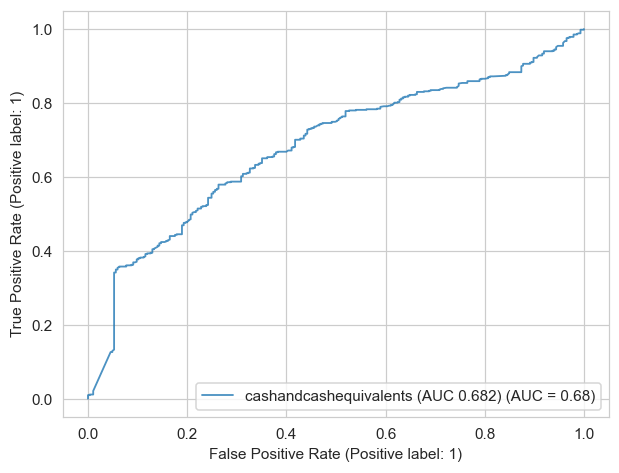

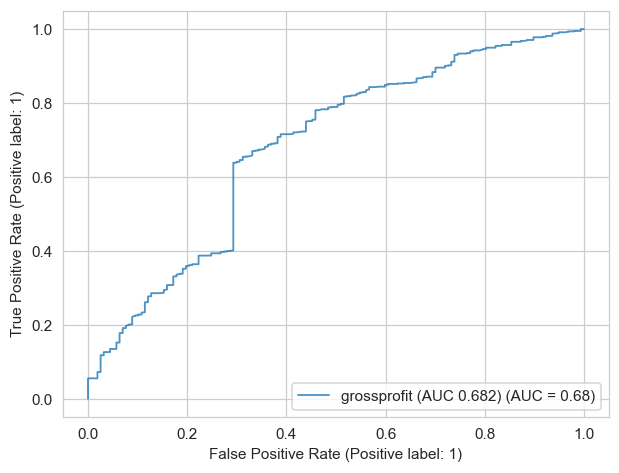

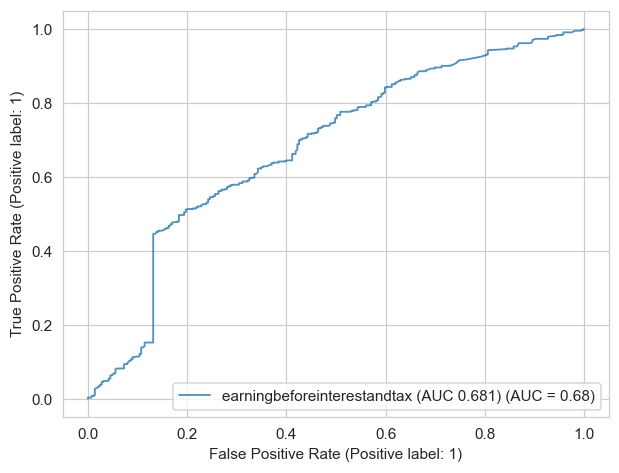

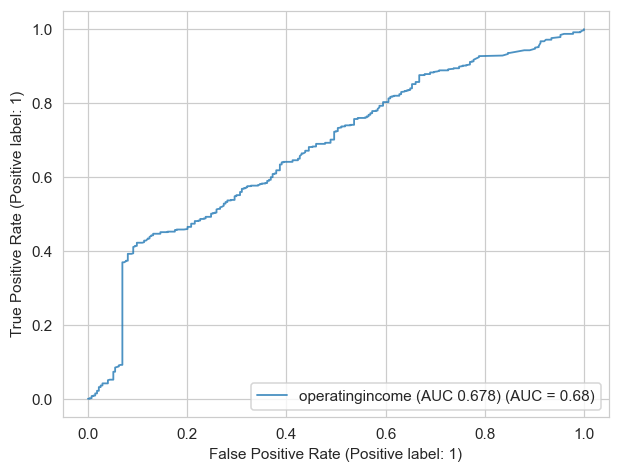

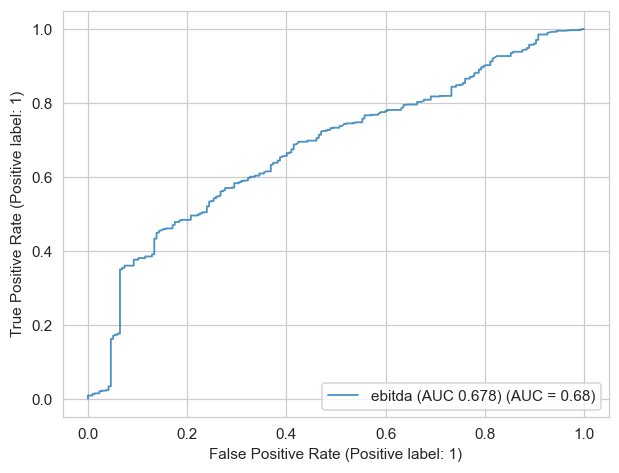

In [ ]:
#!/usr/bin/env python
# =====================================================================
#  STAGE-17 · VALIDATION  +  LONG-HORIZON TRAJECTORY   (v2.3 • 2025-06-17)
# =====================================================================
"""
A. FY-(SWAN-1) hold-out validation for *every* probability column written by
   Stage-11 – including depth / blend / stage families and raw-logit (L1) cols.

B. Seven-year trajectory (-3 … +3) – DiD, mixed-effects and effect-size heat-map.

The script is self-contained and robust to:
    • non-datetime date columns   → coerced to datetime
    • missing post-event years    → dynamic clipping to last year in data
    • outliers / infinite values  → replaced by NaN before averaging
"""
from __future__ import annotations
from pathlib import Path
from typing  import Dict, List
import os, re, logging, warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats      import ttest_ind
from sklearn.metrics  import roc_auc_score, brier_score_loss, RocCurveDisplay

from pipeline_utils import load_cfg, resolve_run_dir
warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams["figure.dpi"] = 110
sns.set_style("whitegrid")

# ═══════════════ 0 · BOOTSTRAP ══════════════════════════════════
CFG: Dict    = load_cfg()
EVENTS: Dict = {str(k): v for k, v in CFG.get("events", {}).items()}

SWAN_YEAR  = str(os.getenv("SWAN_YEAR") or next(iter(EVENTS)))
SWAN_INT   = int(SWAN_YEAR)
PRE_YEAR   = SWAN_INT - 1

RUN_DIR = resolve_run_dir(
    swan_year = SWAN_YEAR,
    run_tag   = os.getenv("RUN_TAG"),
    must_have = f"stage11/11_RISE_Probabilities_All_{SWAN_YEAR}.csv",
)
STAGE_DIR = RUN_DIR / "stage17"; STAGE_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(
    level   = logging.INFO,
    format  = "%(asctime)s | %(levelname)-7s | %(message)s",
    handlers=[logging.FileHandler(STAGE_DIR/"stage17.log", "w", "utf-8"),
              logging.StreamHandler()],
)
log = logging.getLogger("stage17")
log.info("====  STAGE-17  (event %s)  ====", SWAN_YEAR)

# ═══════════════ 1 · INPUT FILES ════════════════════════════════
PROB_CSV  = RUN_DIR/"stage11"/f"11_RISE_Probabilities_All_{SWAN_YEAR}.csv"
STAGE3_CSV= RUN_DIR/"stage03"/f"Stage3_Data_WithRatios_{SWAN_YEAR}.csv"
if not PROB_CSV.is_file():   raise FileNotFoundError(PROB_CSV)
if not STAGE3_CSV.is_file(): raise FileNotFoundError(STAGE3_CSV)

# ═══════════════ 2 · LOAD DATA  (force datetime) ════════════════
def _load(fp: Path, parse_date=False) -> pd.DataFrame:
    df = pd.read_csv(fp, low_memory=False)
    df.columns = df.columns.str.lower().str.strip()
    if parse_date:
        date_cand = [c for c in df.columns if c.endswith("date")]
        if date_cand:
            df[date_cand[0]] = pd.to_datetime(df[date_cand[0]], errors="coerce")
    return df

prob   = _load(PROB_CSV,  True)
stage3 = _load(STAGE3_CSV, True)

DATE_COL = next(c for c in prob.columns if c.endswith("date"))
ID_COL   = next(c for c in prob.columns if c in ("symbol", "ticker", "id"))

# guarantee datetime in Stage-03 as well
if not pd.api.types.is_datetime64_any_dtype(stage3[DATE_COL]):
    stage3[DATE_COL] = pd.to_datetime(stage3[DATE_COL], errors="coerce")

# ═══════════════ 3 · HOLD-OUT VALIDATION (FY-1) ═════════════════
flag_cols = [c for c in stage3.columns if c.startswith("flag_")]
flags_pre = stage3.loc[stage3[DATE_COL].dt.year == PRE_YEAR,
                       [ID_COL, DATE_COL] + flag_cols]
df = prob.merge(flags_pre, on=[ID_COL, DATE_COL], how="inner")

# 3A · probability columns detected
prob_cols: List[str] = [
    c for c in df.columns
    if c.endswith("_prob") and not c.startswith(("mean_", "median_", "zblend_"))
]

# 3B · metric extractor
METRIC_PATTERN = re.compile(
    r"""^(?:rscore(?:depth)?prob_)?        # optional raw-logit prefix
        (?P<metric>[a-z0-9]+?)            # metric core
        (?:_.*)?_prob$                    # trailing flavour suffix
    """, re.X,
)

val_rows = []
for pcol in prob_cols:
    m = METRIC_PATTERN.match(pcol)
    if not m: continue
    metric = m.group("metric")
    flag   = f"flag_{metric}"
    if flag not in df: continue
    sub = df[[pcol, flag]].dropna()
    if len(sub) < 30 or sub[flag].nunique() < 2:
        continue
    val_rows.append({
        "Metric" : metric,
        "ProbCol": pcol,
        "N"      : len(sub),
        "AUROC"  : round(roc_auc_score(sub[flag], sub[pcol]), 3),
        "Brier"  : round(brier_score_loss(sub[flag], sub[pcol]), 4),
    })

val_df = (pd.DataFrame(val_rows)
            .sort_values("AUROC", ascending=False)
            .reset_index(drop=True))
val_df.to_csv(STAGE_DIR/f"Stage17_ValidationSummary_{SWAN_YEAR}.csv", index=False)
log.info("Validation summary written (%d models)", len(val_df))

# ROC – top 12
if not val_df.empty:
    plt.figure(figsize=(6, 5))
    for _, r in val_df.head(12).iterrows():
        sub = df[[r.ProbCol, f"flag_{r.Metric}"]].dropna()
        RocCurveDisplay.from_predictions(
            sub[f"flag_{r.Metric}"], sub[r.ProbCol],
            name=f"{r.Metric} (AUC {r.AUROC})", linewidth=1.2)
    plt.title(f"ROC curves – FY {PRE_YEAR}")
    plt.tight_layout()
    plt.savefig(STAGE_DIR/f"Stage17_ROC_AllMetrics_{SWAN_YEAR}.png", dpi=110)
    plt.close()

# ═══════════════ 4 · 7-YEAR TRAJECTORY  (-3 … +3) ═══════════════
REL_YRS  = range(-3, 4)        # relative years
score_cols = [c for c in stage3.columns if c.startswith("score_")]

prob["mean_prob"] = prob[prob_cols].replace([np.inf, -np.inf], np.nan).mean(axis=1)

anchor = prob.loc[prob[DATE_COL].dt.year == PRE_YEAR, [ID_COL, "mean_prob"]]
cut    = anchor.mean_prob.quantile(.50)                # top-50% = High group
anchor["rgroup"] = np.where(anchor.mean_prob >= cut, "High", "Low")

stage3["year"] = stage3[DATE_COL].dt.year
stage3 = stage3.merge(anchor[[ID_COL, "rgroup"]], on=ID_COL, how="inner")

panel = []
for rel in REL_YRS:
    yr = SWAN_INT + rel
    sub = stage3.loc[stage3.year == yr]
    if sub.empty: continue
    panel.append(sub[[ID_COL, "rgroup"] + score_cols]
                 .assign(rel_year=rel, abs_year=yr))

panel = (pd.concat(panel, ignore_index=True)
           .assign(post=lambda d: (d.rel_year >= 1).astype(int),
                   group_str=lambda d: d[ID_COL].astype(str)))
panel.to_csv(STAGE_DIR/f"Stage17_Panel_{SWAN_YEAR}.csv", index=False)

# 4A · Difference-in-Differences
did_rows = []
for s in score_cols:
    mdl = smf.ols(f"{s} ~ rgroup*post", data=panel).fit(cov_type="HC3")
    did_rows.append({
        "Metric" : s.replace("score_", ""),
        "DiD_beta": mdl.params.get("rgroup[T.High]:post", np.nan),
        "p_value" : mdl.pvalues.get("rgroup[T.High]:post", np.nan),
        "R2_adj"  : mdl.rsquared_adj,
    })
pd.DataFrame(did_rows).round(4)\
  .to_csv(STAGE_DIR/f"Stage17_DiD_Models_{SWAN_YEAR}.csv", index=False)

# 4B · Mixed-effects: one CSV / metric
mix_dir = STAGE_DIR/"Stage17_MixedModels"; mix_dir.mkdir(exist_ok=True)
for s in score_cols:
    out = mix_dir/f"{s.replace('score_','')}_Mixed_{SWAN_YEAR}.csv"
    sub = panel[[s, "rgroup", "rel_year", "group_str"]].dropna()
    if len(sub) < 50:
        pd.DataFrame({"error": ["too few rows"]}).to_csv(out, index=False)
        continue
    try:
        smf.mixedlm(f"{s} ~ rgroup*rel_year", data=sub,
                    groups=sub.group_str).fit(reml=False)\
          .summary().tables[1].to_csv(out)
    except Exception as exc:
        pd.DataFrame({"error": [str(exc)]}).to_csv(out, index=False)

# 4C · Yearly Welch t-tests → Cohen’s d heat-map
t_rows = []
for s in score_cols:
    for r in REL_YRS:
        hi = panel.loc[(panel.rgroup == "High") & (panel.rel_year == r), s].dropna()
        lo = panel.loc[(panel.rgroup == "Low")  & (panel.rel_year == r), s].dropna()
        if len(hi) < 20 or len(lo) < 20:
            continue
        t, p = ttest_ind(hi, lo, equal_var=False, nan_policy="omit")
        d = (hi.mean() - lo.mean()) / np.sqrt((hi.var() + lo.var()) / 2)
        t_rows.append({"Metric": s.replace("score_", ""),
                       "RelYear": r, "t": t, "p": p, "d": d})
t_df = pd.DataFrame(t_rows).round(4).to_csv(
          STAGE_DIR/f"Stage17_ttests_ByYear_{SWAN_YEAR}.csv", index=False)

# heat-map
if t_rows:
    eff = (pd.DataFrame(t_rows)
           .pivot(index="Metric", columns="RelYear", values="d")
           .sort_index())
    plt.figure(figsize=(7, max(3, len(eff) * .4)))
    sns.heatmap(eff, cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title("High – Low: Cohen’s d across years")
    plt.tight_layout()
    plt.savefig(STAGE_DIR/f"Stage17_EffectSizes_Heatmap_{SWAN_YEAR}.png", dpi=110)
    plt.close()

log.info("🎉  Stage-17 complete – artefacts in %s", STAGE_DIR)
print(f"\n✅ Stage-17 complete – outputs in {STAGE_DIR}\n")